In [1]:
from __future__ import print_function
import os
import torchvision.models as models
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib
import time
import copy
import cv2
from PIL import Image

%matplotlib inline

In [2]:
def show_images(loader):
    d = iter(loader)
    images, labels = d.next()
    grid = torchvision.utils.make_grid(images)
    npimg = grid.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    print(labels)
    plt.imshow(npimg)
    plt.show()
    
def show_image_batch(images):
    grid = torchvision.utils.make_grid(images)
    npimg = grid.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    plt.imshow(npimg)
    plt.show()

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            


In [4]:
num_classes = 2
num_epochs = 1
feature_extract = True

In [5]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.mobilenet_v2(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

In [11]:
traindir = os.path.join(os.getcwd(), 'car_train_noveerleft')
testdir = os.path.join(os.getcwd(), 'car_test_noveerleft')

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transform),
    shuffle=True,
    batch_size=16,
    num_workers=2)
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transform),
    batch_size=16,
    num_workers=2)

data_transforms = {
    'train': transform,
    'val': transform
}

dataloaders_dict = {
    'train': train_loader,
    'val': test_loader
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Done Initializing Datasets and Dataloaders...")


Done Initializing Datasets and Dataloaders...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1])


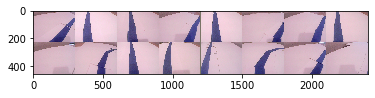

In [7]:
show_images(train_loader)

In [12]:
# Send the model to GPU/CPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(params_to_update)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [13]:
# Setup the loss fxn
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0777 Acc: 0.9763
val Loss: 0.0964 Acc: 0.9513

Epoch 1/9
----------
train Loss: 0.0554 Acc: 0.9813
val Loss: 0.1564 Acc: 0.9468

Epoch 2/9
----------
train Loss: 0.0769 Acc: 0.9778
val Loss: 0.0917 Acc: 0.9631

Epoch 3/9
----------
train Loss: 0.0475 Acc: 0.9845
val Loss: 0.1339 Acc: 0.9542

Epoch 4/9
----------
train Loss: 0.0650 Acc: 0.9775
val Loss: 0.0995 Acc: 0.9601

Epoch 5/9
----------
train Loss: 0.0469 Acc: 0.9852
val Loss: 0.0800 Acc: 0.9601

Epoch 6/9
----------
train Loss: 0.0414 Acc: 0.9860
val Loss: 0.1164 Acc: 0.9572

Epoch 7/9
----------
train Loss: 0.0476 Acc: 0.9845
val Loss: 0.0718 Acc: 0.9690

Epoch 8/9
----------
train Loss: 0.0639 Acc: 0.9786
val Loss: 0.0752 Acc: 0.9690

Epoch 9/9
----------
train Loss: 0.0379 Acc: 0.9864
val Loss: 0.0863 Acc: 0.9749

Training complete in 96m 54s
Best val Acc: 0.974889


In [14]:
torch.save(model_ft, './models/model_carimages_NOVEERLEFT_20191106-20-46.pt')

In [11]:
torch.save({'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict()
            }, './state_dict_blue_20191104-12-02')

tensor([[[1.2899, 1.2728, 1.2899,  ..., 1.4269, 1.4269, 1.4098],
         [1.2899, 1.2728, 1.2728,  ..., 1.4269, 1.4269, 1.4269],
         [1.2899, 1.2728, 1.2728,  ..., 1.4098, 1.4269, 1.4440],
         ...,
         [1.4954, 1.4783, 1.4440,  ..., 1.4440, 1.4440, 1.4098],
         [1.4954, 1.4783, 1.4612,  ..., 1.4440, 1.4440, 1.4269],
         [1.5125, 1.4783, 1.4269,  ..., 1.4440, 1.4440, 1.4440]],

        [[0.9405, 0.9230, 0.9405,  ..., 1.0805, 1.0805, 1.0630],
         [0.9405, 0.9230, 0.9230,  ..., 1.0805, 1.0805, 1.0805],
         [0.9405, 0.9230, 0.9230,  ..., 1.0630, 1.0805, 1.0980],
         ...,
         [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
         [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
         [1.1506, 1.1331, 1.1155,  ..., 1.0805, 1.0805, 1.0805]],

        [[0.5136, 0.4962, 0.5136,  ..., 0.6008, 0.6182, 0.6008],
         [0.5136, 0.4962, 0.4962,  ..., 0.6182, 0.6182, 0.6182],
         [0.5136, 0.4962, 0.4962,  ..., 0.6008, 0.6182, 0.

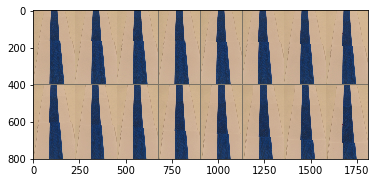

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [29]:
labels = {0: 'straight', 1: 'right'}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        print(images[0])
        outputs = model_ft(images)
        show_image_batch(images)
        _, predicted = torch.max(outputs.data, 1)
#         print(labels[predicted.item()])
        print(predicted)
        break;

tensor([[[[1.2899, 1.2728, 1.2899,  ..., 1.4269, 1.4269, 1.4098],
          [1.2899, 1.2728, 1.2728,  ..., 1.4269, 1.4269, 1.4269],
          [1.2899, 1.2728, 1.2728,  ..., 1.4098, 1.4269, 1.4440],
          ...,
          [1.4954, 1.4783, 1.4440,  ..., 1.4440, 1.4440, 1.4098],
          [1.4954, 1.4783, 1.4612,  ..., 1.4440, 1.4440, 1.4269],
          [1.5125, 1.4783, 1.4269,  ..., 1.4440, 1.4440, 1.4440]],

         [[0.9405, 0.9230, 0.9405,  ..., 1.0805, 1.0805, 1.0630],
          [0.9405, 0.9230, 0.9230,  ..., 1.0805, 1.0805, 1.0805],
          [0.9405, 0.9230, 0.9230,  ..., 1.0630, 1.0805, 1.0980],
          ...,
          [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
          [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
          [1.1506, 1.1331, 1.1155,  ..., 1.0805, 1.0805, 1.0805]],

         [[0.5136, 0.4962, 0.5136,  ..., 0.6008, 0.6182, 0.6008],
          [0.5136, 0.4962, 0.4962,  ..., 0.6182, 0.6182, 0.6182],
          [0.5136, 0.4962, 0.4962,  ..., 0

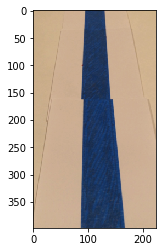

tensor([[ 3.5926, -3.2478]])


In [35]:
with torch.no_grad():
    model_ft.eval()
    img = cv2.imread('/Users/bryantpham/Documents/fa19/ML/FinalProject/testimgs/test-blue-straight-1-000001.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    t = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = t(img).float()
    img = img.unsqueeze(0)
    img = torch.autograd.Variable(img)
    print(img)
    show_image_batch(img)

    outputs = model_ft(img)
    _, predicted = torch.max(outputs.data, 1)
    print(outputs)